In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.ops import MLP
from tqdm.notebook import trange

* Write a validation step
* Experiment with `MLP` options
* Implement a CNN

Data: X.shape=(20000, 64, 64) Y.shape=(20000, 2)


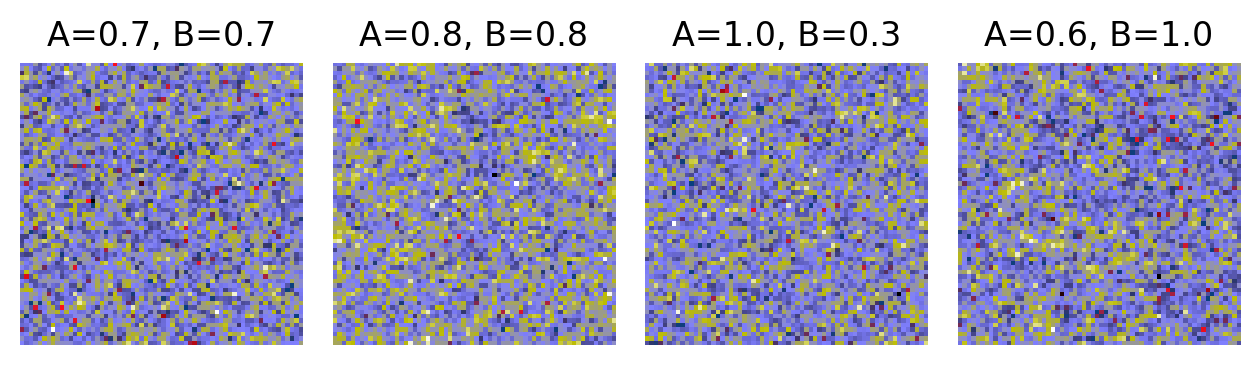

In [2]:
field_type = "G" #"LN"
data_dir = "data/"

lower = np.array([.1, .1])
upper = np.array([1., 1.])

X = np.load(os.path.join(data_dir, field_type + "_fields.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

print(f"Data: {X.shape=} {Y.shape=}")

fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(X[i], cmap="gist_stern")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
# Data
data_dim = np.prod(X.shape[1:])
parameter_dim = Y.shape[-1]
# Model
H = [512, 128, 32]
activation = nn.Tanh
# Optimisation
n_steps = 2000
lr = 1e-3
batch_size = 400

# Experiment with args here
net = MLP(
    data_dim, 
    H + [parameter_dim], 
    activation_layer=activation,
    bias=True,
    dropout=0.
)

In [4]:
def convert(x):
    return torch.as_tensor(x).float()

def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return convert(X[ix]).flatten(1), convert(Y[ix])

In [5]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = loss_fn(net(x), y)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses += [loss.item()]
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/2000 [00:00<?, ?it/s]

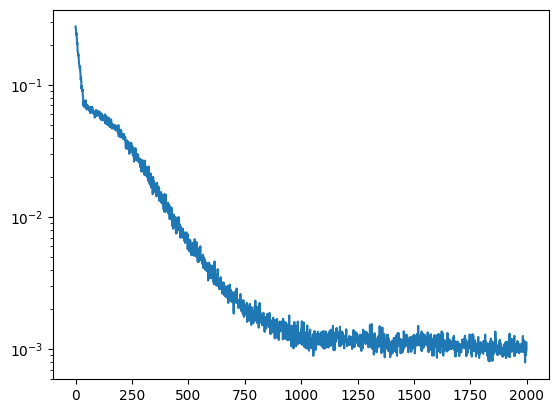

In [6]:
plt.semilogy(losses)
plt.show()

In [7]:
alpha = np.load(os.path.join(data_dir, field_type + "_alpha.npy"))
mean = np.load(os.path.join(data_dir, field_type + "_mean.npy"))
covariance = np.load(os.path.join(data_dir, field_type + "_covariance.npy"))

data = np.random.multivariate_normal(mean.flatten(), covariance)

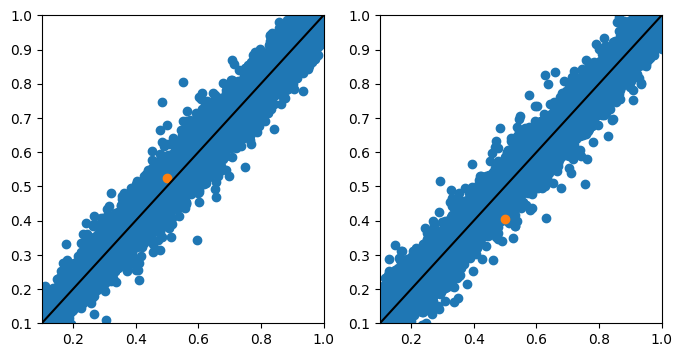

In [12]:
net = net.eval()

Y__ = net(convert(data)).detach().numpy()
Y__mean = net(convert(mean.flatten()[None, :])).detach().numpy()
Y_ = net(convert(X).flatten(1)).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(8., 4.))
ax = axs[0]
ax.scatter(Y[:, 0], Y_[:, 0])
ax.scatter(alpha[0], Y__[0])
ax.set_xlim(lower[0], upper[0])
ax.set_ylim(lower[0], upper[0])
ax.axline((0, 0), slope=1, color="k")
ax = axs[1]
ax.scatter(Y[:, 1], Y_[:, 1])
ax.scatter(alpha[1], Y__[1])
ax.set_xlim(lower[1], upper[1])
ax.set_ylim(lower[1], upper[1])
ax.axline((0, 0), slope=1, color="k")
plt.show()

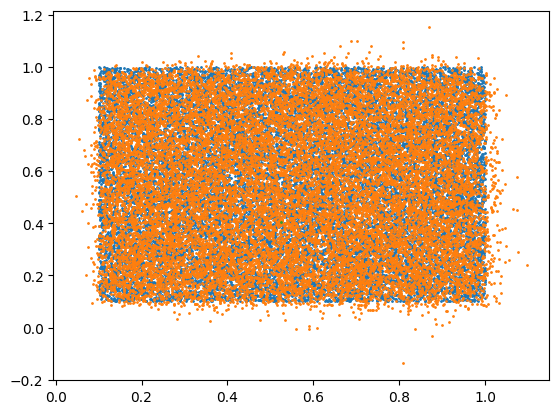

In [13]:
plt.figure()
plt.scatter(*Y.T, s=1.)
plt.scatter(*Y_.T, s=1.)
plt.scatter(*Y__.T, s=1.)
plt.show()

In [14]:
# Save output summaries for simulations + data
np.save(os.path.join(data_dir, field_type + "_nn_summary_mean.npy"), Y__mean)
np.save(os.path.join(data_dir, field_type + "_nn_summary_data.npy"), Y__)
np.save(os.path.join(data_dir, field_type + "_nn_summaries.npy"), Y_)